In [65]:
import gzip
import math
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt', encoding='cp437', errors='ignore'):
        yield eval(l)

In [4]:
dataset = []
for l in readGz("australian_users_items.json.gz"):
    dataset.append(l)

In [60]:
pairs = []
for d in dataset:
    for i in d['items']:
        pairs.append((d['user_id'], i['item_id'], i['playtime_forever']))

In [61]:
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)

for p in pairs:
    u = p[0]
    i = p[1]
    t = p[2]
    if t > 2:
        itemsPerUser[u].add(i)
        usersPerItem[i].add(u)

In [62]:
len(itemsPerUser)
# number of unique users in the dataset

68217

In [63]:
len(usersPerItem)
# number of unique games in the dataset

9831

In [64]:
len(dataset)

88310

In [10]:
count = 0
for d in dataset:
    if len(d["items"]) == 0 :
        count += 1
count

16806

In [11]:
userId = [d["steam_id"] for d in dataset]

In [12]:
userId = np.array(userId)

In [13]:
unique, counts = np.unique(userId, return_counts=True)

In [34]:
gameCounts = defaultdict(int)
for d in dataset:
    for g in d["items"]:
        if g["playtime_forever"] > 0:
            gameCounts[g["item_name"]] += 1

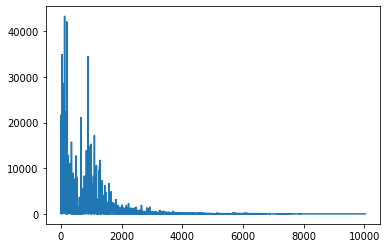

In [35]:
plt.plot(np.array(list(gameCounts.values())))
plt.show()

In [36]:
np.mean(np.array(list(gameCounts.values())))

327.7380287310455

In [37]:
np.median(np.array(list(gameCounts.values())))

24.0

In [38]:
np.mean(np.array(list(gameCounts.values())) > 4000)

0.01775738228252195

In [100]:
pairsBool = []
playtime = []
for d in dataset:
    for i in d['items']:
        pairsBool.append((d['user_id'], i['item_id'],i['playtime_forever'] > 2))
        #playtime.append(i['playtime_forever']>2)

In [101]:
# train and test data split
# only selecting users with 3 or more games in their item list
random.shuffle(pairsBool)


In [102]:
len(pairsBool)//4*3

3864906

In [103]:
trainBool = pairsBool[:len(pairsBool)//4*3]
valBool = pairsBool[len(pairsBool)//4*3:]

In [115]:
itemsPerUserTrain = defaultdict(set)
usersPeritemTrain = defaultdict(set)

for user,game,play in trainBool:
    if play:
        itemsPerUserTrain[user].add(game)
        usersPeritemTrain[game].add(user)

In [67]:
# using jaccard similarity for predicting
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [120]:
def jaccard_baseline_pred(val, threshold):
    count = 0
    acc = 0
    # takes a game and user from val
    for user,game,play in val:
        #if count%100 == 0: print(count)
        count+=1
        max_jaccard = 0
        # for each game the user made
        for rec in itemsPerUser[user]:
            if game == rec:
                continue
            # find jaccard of user 
            jacc = Jaccard(usersPeritemTrain[game], usersPeritemTrain[rec])
            
            if jacc > max_jaccard:
                max_jaccard = jacc
                # threshold is broken
                if jacc > threshold: 
                    
                    break
        #print("max_jacc: {0} , threshold: {1} , play: {2} , count: {3}".format(max_jaccard, threshold,play,count))
        if (max_jaccard > threshold) == (play == 1):
            acc += 1

    return acc / len(val)

In [122]:
jaccard_baseline_pred(valBool[:500],0.15)

0.602

In [123]:
random.shuffle(valBool)

accJaccard = []
thresholdJacc = np.arange(0,0.2,0.05)
for t in thresholdJacc:
    # take a smaller subset because it takes too long
    randomSample = random.sample(valBool,500)
    a = jaccard_baseline_pred(randomSample,t)
    accJaccard.append(a)

Text(0, 0.5, 'Accuracy')

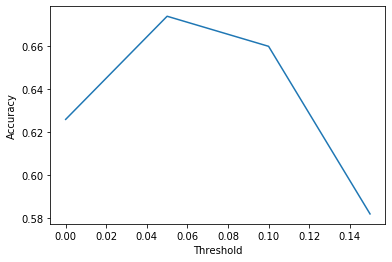

In [124]:
plt.plot(thresholdJacc, accJaccard)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")